# pop-comos: Generating a mock galaxy catalog

This notebook will demonstrate how to use the `pop_cosmos` package to generate a COSMOS-like mock galaxy catalog.

We'll start by importing some dependencies, and the relevant submodules from `pop_cosmos`. Before you run this notebook, you should follow the installation instructions in the `README.md`

In [1]:
#Import dependencies and pop_cosmos
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

from astropy.cosmology import Planck18

from pop_cosmos.constants import COSMOS_FILTERS_LATEX
from pop_cosmos.catalogue import CatalogueGenerator
from pop_cosmos.emlines import EmLineEmulator
from pop_cosmos.utils import compute_derived_quantities, compute_mass_remaining

## Load the trained model(s)

In the next cell we will load a pickled `pop_cosmos.catalogue.CatalogueGenerator` object that contains the Thorp et al. (2025) version of the `pop-cosmos` model.

In [3]:
#Load model trained in Thorp et al. (2025) on the CPU
catalogue_generator = torch.load("../trained_models/catalogueModelT25.pt", weights_only=False)

And now, we will load in an additional emulator that is needed to correct the stellar masses predicted by the model (which by default are the stellar mass _formed_ by a galaxy over its lifetime) for mass loss (so we will end up with stellar mass _remaining_).

In [4]:
#Load a secondary emulator needed for some derived quantities
mass_remaining_emulator = torch.load("../trained_models/stellar_mass_emulator.pt", map_location="cpu", weights_only=False)
mass_theta_shift, mass_theta_scale = pickle.load(open("../trained_models/stellar_mass_parameter_shift-scale.pkl", "rb"))
mass_theta_shift = torch.from_numpy(mass_theta_shift)
mass_theta_scale = torch.from_numpy(mass_theta_scale)

## Generating base samples

The different parts of the `CatalogueGenerator` transform a set of base draws that are sampled from some simple distributions. The `generate_base_samples` method will give us these. We'll call it below to generate 10000 draws from the base densities.

In [5]:
#Generate base samples for the diffusion model
base_noise, base_sigma, base_phi = catalogue_generator.generate_base_samples(10000)

## Generating a mock

Now, we can push the base samples through the full generative model, to produce the following quantities:
 * `noisy_fluxes`: 26-band COSMOS-like fluxes in maggies
 * `noisy_magnitudes`: 26-band logarithmic AB magnitudes
 * `noisy_asinh_magnitudes`: 26-band asinh magnitudes
 * `flux_sigmas`: Flux uncertainties in maggies
 * `theta_samples`: 16 SPS parameters
 * `model_fluxes`: Noiseless "true" fluxes in maggies
 
Our basic parameter list in `theta_samples` will contain the following:
$$
    [N, 
    \log_{10}(Z/Z_\odot), 
    \Delta\log_{10}(\text{SFR})_2, 
    \Delta\log_{10}(\text{SFR})_3, 
    \Delta\log_{10}(\text{SFR})_4,
    \Delta\log_{10}(\text{SFR})_5,
    \Delta\log_{10}(\text{SFR})_6,
    \Delta\log_{10}(\text{SFR})_7,
    \tau_2,
    n,
    \tau_1/\tau_2,
    \ln(f_\text{AGN}),
    \ln(\tau_\text{AGN}),
    \log_{10}(Z_\text{gas}/Z_\odot),
    \log_{10}(U_\text{gas}),
    z]
$$
You can find definitions of these in Table 2 of Thorp et al. (2025). The only unfamiliar one is the first parameter, defined as $N=\mu-2.5\log_{10}(M/M_\odot)$, where $\mu$ is the distance modulus.

In [6]:
#Generate a representative catalogue from the model
noisy_fluxes, noisy_magnitudes, noisy_asinh_magnitudes, flux_sigmas, theta_samples, model_fluxes = catalogue_generator(base_noise, base_sigma, base_phi)

## Process the catalog

Here, we will apply a few operations to the mock catalog. This will compute an IRAC $\textit{Ch.1}<26$ selection for the model galaxies, and will compute some derived quantities that will be useful. We'll pass `return_bins=True` to the derived quantities function, to compute the fraction of mass formed and average SFR per bin of each galaxy's star formation history (as was done in Deger et al. 2025). 

In [7]:
#Set the magnitude limit to 26 in IRAC Ch.1
lims = torch.inf*torch.ones(26)
lims[-2] = 26.0

#Generate a boolean tensor with information on which galaxies are selected
selection = catalogue_generator.selection_cut(noisy_fluxes, noisy_magnitudes, flux_sigmas, lims).detach().numpy()

#Compute some derived quantities that we might want
log10M_formed, mw_age, log10SFR, log10sSFR, M_frac_bins, log10SFR_bins, t_edge_bins = compute_derived_quantities(theta_samples, return_bins=True)
log10M_remain, log10sSFR, M_frac_remain = compute_mass_remaining(log10M_formed, log10sSFR, theta_samples, mass_theta_shift, mass_theta_scale, mass_remaining_emulator)

#Move to numpy
noisy_magnitudes = noisy_magnitudes.detach().numpy()
noisy_fluxes = noisy_fluxes.detach().numpy()
flux_sigmas = flux_sigmas.detach().numpy()
theta_samples = theta_samples.detach().numpy()
log10M_samples = log10M_remain.detach().numpy()
log10SFR_samples = log10SFR.detach().numpy()
log10sSFR_samples = log10sSFR.detach().numpy()

# SFH-related quantities
t_edge_samples = t_edge_bins.detach().numpy()
M_frac_samples = M_frac_bins.detach().numpy()
log10SFH_samples = log10SFR_bins.detach().numpy()

## Apply the selection cut

Here we'll apply the selection cut to some of the arrays we'll be using in the next steps of the notebook.

In [8]:
#Make the selection cut
noisy_magnitudes_selected = noisy_magnitudes[selection]
noisy_flux_sigmas_selected = flux_sigmas[selection]
thetas_selected = theta_samples[selection]
log10M_selected = log10M_samples[selection]
log10SFR_selected = log10SFR_samples[selection]
log10sSFR_selected = log10sSFR_samples[selection]
t_edge_selected = t_edge_samples[selection]
M_frac_selected = M_frac_samples[selection]
log10SFH_selected = log10SFH_samples[selection]

#### TEMP MY OWN WORK:
Pop cosmos catalog loaded above into memory, 
log10m_selected - stellar mass remaining
log10SFR_selected - start formation rate.

Lets plot Stellar mass vs star-formation rate


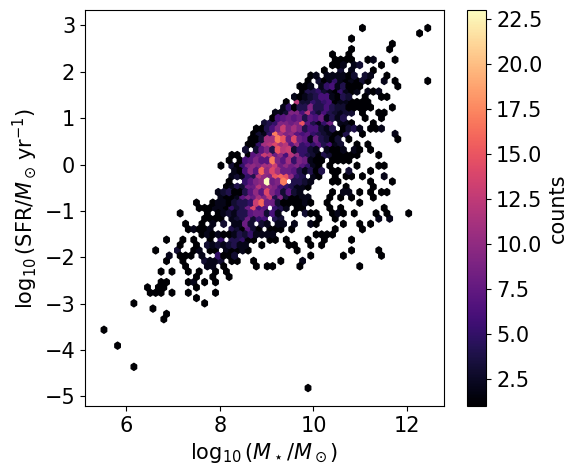

In [10]:
import matplotlib.pyplot as plt

# Stellar mass vs SFR (star-forming main sequence style plot)
plt.figure(figsize=(6, 5))
hb = plt.hexbin(log10M_selected, log10SFR_selected, gridsize=60, cmap="magma", mincnt=1)
plt.colorbar(hb, label="counts")
plt.xlabel(r"$\log_{10}(M_\star/M_\odot)$")
plt.ylabel(r"$\log_{10}(\mathrm{SFR}/M_\odot\,\mathrm{yr}^{-1})$")
plt.tight_layout()
plt.show()

Plot seems to be accurate, main seq star forming rate. Positive correlation.
Lets try color coding the main seq stars by red shift, can see how the main seq evolves with redshift

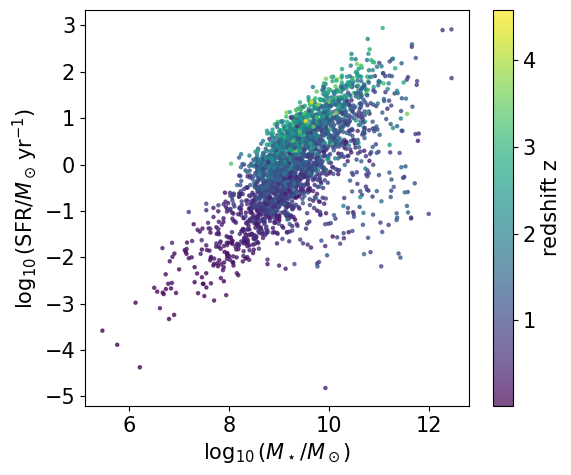

In [11]:
import matplotlib.pyplot as plt

z_selected = thetas_selected[:, -1]

plt.figure(figsize=(6, 5))
sc = plt.scatter(log10M_selected, log10SFR_selected,
                 c=z_selected, s=5, cmap="viridis", alpha=0.7)
cbar = plt.colorbar(sc)
cbar.set_label("redshift z")
plt.xlabel(r"$\log_{10}(M_\star/M_\odot)$")
plt.ylabel(r"$\log_{10}(\mathrm{SFR}/M_\odot\,\mathrm{yr}^{-1})$")
plt.tight_layout()
plt.show()

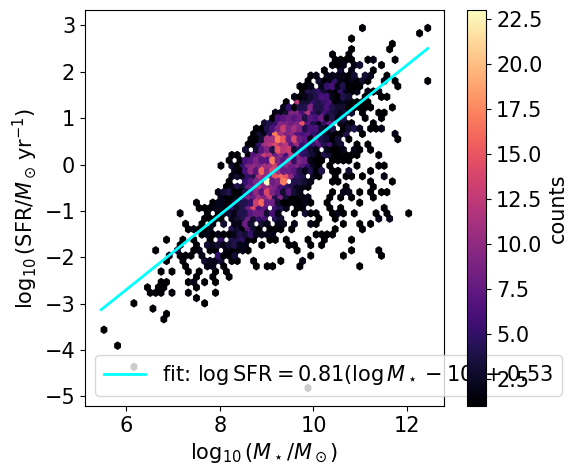

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Hexbin background
plt.figure(figsize=(6, 5))
hb = plt.hexbin(log10M_selected, log10SFR_selected,
                gridsize=60, cmap="magma", mincnt=1)
plt.colorbar(hb, label="counts")

# Straight-line fit: log SFR = a (logM - 10) + b
x = log10M_selected
y = log10SFR_selected
mask = np.isfinite(x) & np.isfinite(y)
a, b = np.polyfit(x[mask] - 10.0, y[mask], 1)

x_plot = np.linspace(x.min(), x.max(), 100)
y_plot = a * (x_plot - 10.0) + b
plt.plot(x_plot, y_plot, color="cyan", lw=2,
         label=fr"fit: $\log\mathrm{{SFR}} = {a:.2f}(\log M_\star-10)+{b:.2f}$")
plt.legend()

plt.xlabel(r"$\log_{10}(M_\star/M_\odot)$")
plt.ylabel(r"$\log_{10}(\mathrm{SFR}/M_\odot\,\mathrm{yr}^{-1})$")
plt.tight_layout()
plt.show()

As I understand:
Each point is one mock galaxy from our pop-cosmos catalog
x axis - log10 of the stellar mass remaining in solar masses.
y axis - log10 of star formation rate
so diagonal band is the SF main seq, more massive galaxies tend to have higher SFR.

when redshift added we see that higher z galaxies (distant, older) tend to have higher SFR. 

For the Aladin viewing, I'll use the region as seen in the Sanders paper 


 COSMOS field, a 2 deg^2 equatorial region centered at RA = 10h 00m 28.6s, Dec = +02d 12m 21s (J2000). The field was selected to avoid bright X‑ray, UV and radio sources and is accessible to all major ground‑based and space‑based optical/IR facilities.

## Magnitude distributions

Now we can plot the broadband magnitudes of the selected mock galaxy population. This will give us something a bit like Figure 1 in Thorp et al. (2025).

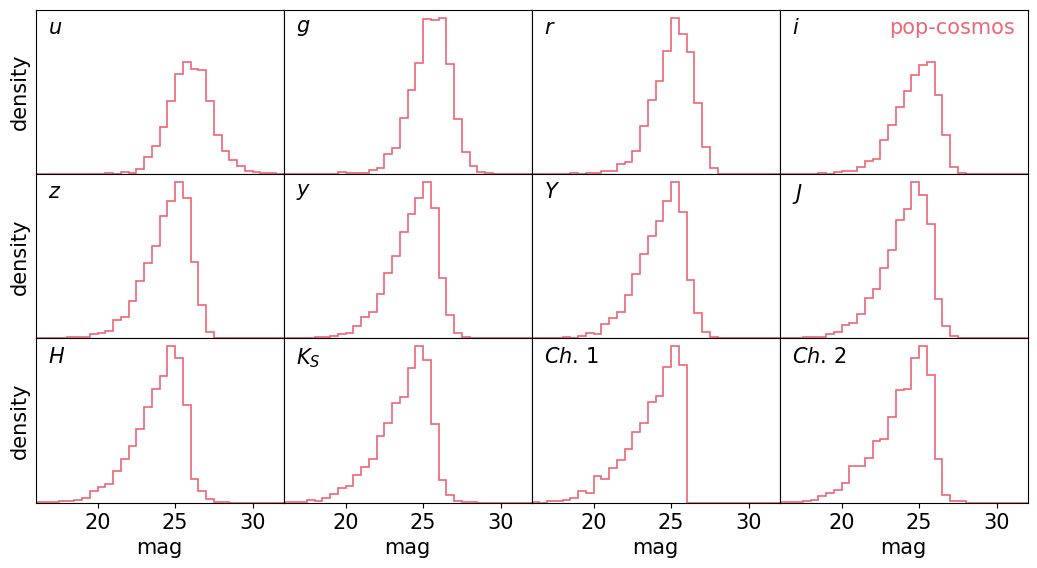

In [9]:
#Plot the broadband magnitudes(logarithmic) as predicted by the pop-cosmos model
plt.rcParams.update({"font.size": 15})
mag_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -2, -1]

x_bins = np.linspace(16, 32, 33)
hist_color = "#EE6677"
figsize = (12.8, 6.4)
xlim = (16, 32)
xticks = [20, 25, 30]

fig, axes = plt.subplots(3, 4, figsize=figsize)
axes = axes.flatten()

# Loop through all channels for a histogram plot
for i, mag_idx in enumerate(mag_list):
    ax = axes[i]
    
    ax.hist(noisy_magnitudes_selected[:, mag_idx], 
            color=hist_color, bins=x_bins, histtype="step", 
            linewidth=1.2, density=True)
    
    # Filter labels
    ax.text(0.05, 0.95, COSMOS_FILTERS_LATEX[mag_idx], 
            transform=ax.transAxes, verticalalignment='top')
    
    if i == 3:
        ax.text(0.95, 0.95, "pop-cosmos", transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment="right", 
                color=hist_color)
    
    if i in [0, 3]: 
        ax.set_ylim(0, ax.get_ylim()[1] * 1.4)

    if i % 4 == 0: 
        ax.set_ylabel('density')
    ax.set_yticks([])
    
    ax.set_xlim(xlim)
    if i > 7: 
        ax.set_xlabel('mag')
        ax.set_xticks(xticks)
    else:
        ax.set_xticks([])

plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

## Colour distributions

Now we can plot the broadband colours of the selected mock galaxy population. This will give us something a bit like Figure 2 in Thorp et al. (2025).

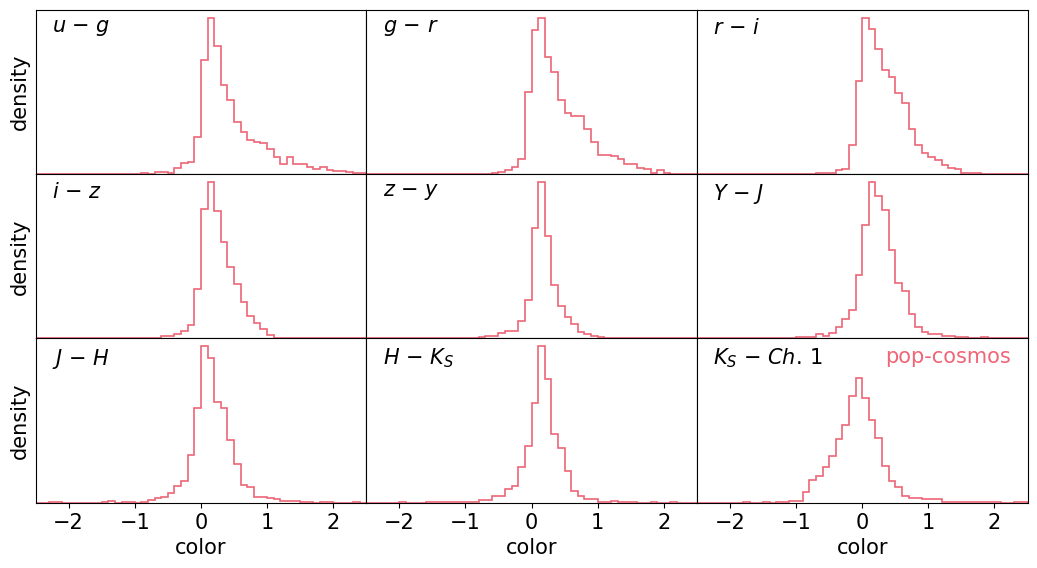

In [9]:
# Plot the broadband colors (logarithmic, adjacent bands) as predicted by the pop-cosmos model
mag_list = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, -2]
x_bins = np.linspace(-2.5, 2.5, 51)
hist_color = "#EE6677"
figsize = (12.8, 6.4)
xlim = (-2.5, 2.5)
xticks = [-2, -1, 0, 1, 2]

# Create color pairs
color_pairs = [(mag_list[i], mag_list[i+1]) 
               for i in range(len(mag_list)-1) 
               if i != 5]


fig, axes = plt.subplots(3, 3, figsize=figsize)
axes = axes.flatten()

# Loop through all color pairs to create a histogram plot
for plot_idx, (mag1, mag2) in enumerate(color_pairs):
    ax = axes[plot_idx]
    
    # Calculate color difference
    color_diff = noisy_magnitudes_selected[:, mag1] - noisy_magnitudes_selected[:, mag2]
    

    ax.hist(color_diff, color=hist_color, bins=x_bins, 
            histtype="step", linewidth=1.2, density=True)
    

    color_label = f"{COSMOS_FILTERS_LATEX[mag1]} $-$ {COSMOS_FILTERS_LATEX[mag2]}"
    ax.text(0.05, 0.95, color_label, transform=ax.transAxes, 
            verticalalignment='top')
    
 
    if plot_idx == 8:
        ax.text(0.95, 0.95, "pop-cosmos", transform=ax.transAxes, 
                verticalalignment='top', horizontalalignment="right", 
                color=hist_color)
        ax.set_ylim(0, ax.get_ylim()[1] * 1.25)
    

    if plot_idx % 3 == 0:  
        ax.set_ylabel('density')
    ax.set_yticks([])
    

    ax.set_xlim(xlim)
    if plot_idx >= 6: 
        ax.set_xlabel('color')
        ax.set_xticks(xticks)
    else:
        ax.set_xticks([])


plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

## Plot the $n(z)$

Now, we'll plot the redshift distribution of the mock galaxy catalog.

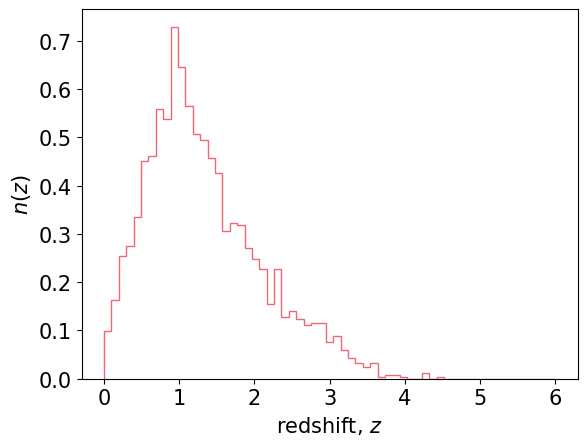

In [10]:
#Plot the reshift distribution predicted by the pop-cosmos model
plt.hist(thetas_selected[:,-1], bins=61, color="#EE6677", histtype="step", density=True, range=(0,6))
plt.xlabel("redshift, $z$")
plt.ylabel("$n(z)$")
plt.show()

## Plot the $n(M)$

Now, we'll plot the mass distribution of the mock galaxy catalog.

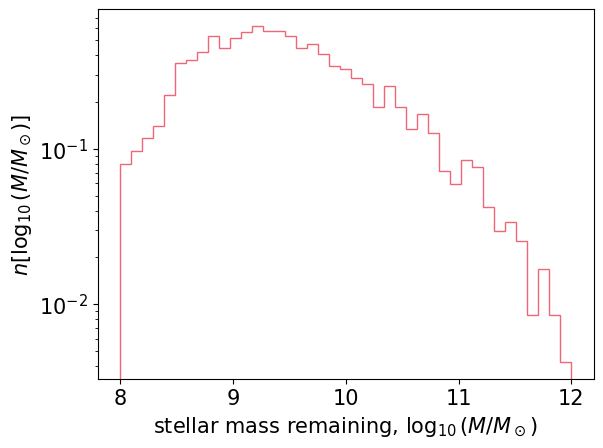

In [11]:
#Plot the stellar mass function predicted by the pop-cosmos model
plt.hist(log10M_selected, bins=41, color="#EE6677", histtype="step", density=True, range=(8,12))
plt.xlabel("stellar mass remaining, $\\log_{10}(M/M_\\odot)$")
plt.ylabel("$n[\\log_{10}(M/M_\\odot)]$")
plt.yscale("log")
plt.show()

## Plot some star formation histories

Now, we'll try to plot some model star formation histories in the style of Deger et al. (2025).

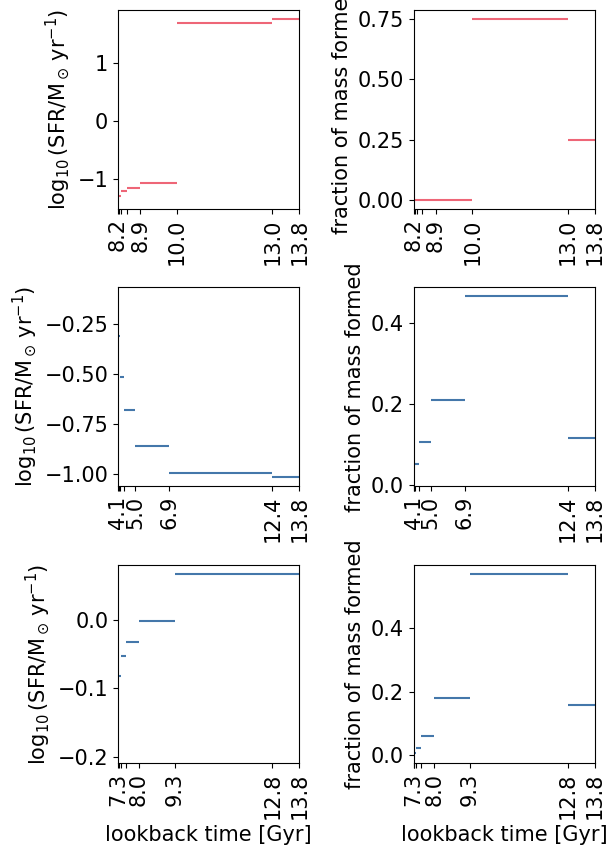

In [12]:
#Choose three random model galaxies and plot their SFH
idx = np.random.choice(len(log10SFH_selected), 3, replace=False)
fig, axes = plt.subplots(3, 2, figsize=(6.4, 8.8), sharex='row')

for j, i in enumerate(idx):
    t_edge = t_edge_selected[i] + Planck18.lookback_time(thetas_selected[i,-1]).value
    t_width = t_edge_selected[i,1:] - t_edge_selected[i,:-1]
    #Red if Q, blue if SF
    color = '#EE6677' if log10sSFR_selected[i] < -11 else '#4477AA'
    #We'll use a horizontal errorbar as a quick way to plot the piecewise constant functions
    axes[j,0].errorbar(t_edge[:-1], log10SFH_selected[i], xerr=[np.zeros_like(t_width), t_width], linestyle='', color=color)
    axes[j,1].errorbar(t_edge[:-1], M_frac_selected[i], xerr=[np.zeros_like(t_width), t_width], linestyle='', color=color)
    axes[j,0].set_xlim(t_edge[0], t_edge[-1])
    axes[j,0].set_ylabel('$\\log_{10}(\\mathrm{SFR}/\\mathrm{M}_\\odot\\,\\mathrm{yr}^{-1}$)')
    axes[j,1].set_ylabel('fraction of mass formed')
    axes[j,0].set_xticks(t_edge, [np.round(t_edge[0],1)] + ['']*3 + list(np.round(t_edge[-4:],1)), rotation=90)
    axes[j,1].set_xticks(t_edge, [np.round(t_edge[0],1)] + ['']*3 + list(np.round(t_edge[-4:],1)), rotation=90)
axes[-1,0].set_xlabel('lookback time [Gyr]')
axes[-1,1].set_xlabel('lookback time [Gyr]')
plt.tight_layout()
plt.show()

## Generate magnitudes for a different survey

Now, we can load in some different photometry emulators, and can generate some model magnitudes in those bands. We'll only be able to generate model fluxes or magnitudes (for now), as we don't have a noise model. We can try generating magnitudes for the Vera Rubin Observatory's and Roman Space Telescope's filters, using the emulators from `trained_models/photulator_models`. 

We can also add emission line strength corrections using the models from `trained_models/emline_bandpass_models` and `trained_models/emline_speculator_models`.

In [13]:
#Load in a Photulator model stack for the Rubin/LSST filters
from speculator import PhotulatorModelStack
emulator_path = '../trained_models/photulator_models/LSST/'
emulator_name = 'model_4x128_alsing20_lsst_baseline_1_9_{}_cpu.pt'
rubin_filter_names = 'ugrizy'
rubin_filter_colors = ["#0c71ff", "#49be61", "#c61c00", "#ffc200", "#f341a2", "#5d0000"]
rubin_flux_emulator = PhotulatorModelStack('', [emulator_path + emulator_name.format(f) 
                                                for f in rubin_filter_names])

#Load in a Photulator model stack for the Roman/WFI filters
from speculator import PhotulatorModelStack
emulator_path = '../trained_models/photulator_models/Roman/'
emulator_name = 'model_4x128_alsing20_roman_wfi_f{}_cpu.pt'
roman_filter_names = ['062', '087', '106', '129', '146', '158', '184', '213']
roman_filter_colors = ["#0011cf", "#8a2be2", "#3cb372", "#ff8d02", "#666666", "#ff4500", "#fe00ff", "#ff0300"]
roman_flux_emulator = PhotulatorModelStack('', [emulator_path + emulator_name.format(f) 
                                                for f in roman_filter_names])

In [14]:
#Build an EmLineEmulator for the Rubin/LSST filters
rubin_emline_flux_emulator = EmLineEmulator('../trained_models/emline_speculator_models/',
                                                   '../trained_models/emline_bandpass_models/LSST/',
                                                   'cpu', 
                                                   ['lsst_baseline_1_9_{}'.format(f) 
                                                    for f in rubin_filter_names],
                                                    n_parameters=16,
                                                    n_hidden=[128, 128, 128])
#Build an EmLineEmulator for the Roman/WFI filters
roman_emline_flux_emulator = EmLineEmulator('../trained_models/emline_speculator_models/',
                                                   '../trained_models/emline_bandpass_models/Roman/',
                                                   'cpu', 
                                                   ['roman_wfi_f{}'.format(f) 
                                                    for f in roman_filter_names],
                                                    n_parameters=16,
                                                    n_hidden=[128, 128, 128])

We can generate Rubin and Roman magnitudes by passing the SPS parameters from our mock catalog through the emulator model stack. The calling signature for the `magnitudes` method of the `PhotulatorModelStack` will need us to use a parameter transform that we can get from the `CatalogueGenerator` we loaded in earlier.

In [15]:
#Transform the base SPS parameters into the format the emulators need
thetas_transformed = catalogue_generator.emulator_parameter_transform(torch.from_numpy(thetas_selected))
# We have to seperate the first column as a second argument to the emulator
rubin_magnitudes = rubin_flux_emulator.magnitudes(thetas_transformed[:,1:], thetas_transformed[:,0].unsqueeze(-1))
rubin_magnitudes = rubin_magnitudes.detach().cpu().numpy()
# Same calculation for Roman bands
roman_magnitudes = roman_flux_emulator.magnitudes(thetas_transformed[:,1:], thetas_transformed[:,0].unsqueeze(-1))
roman_magnitudes = roman_magnitudes.detach().cpu().numpy()

The `EmLineEmulator` will expect the same transformed parameter tensor as the `PhotulatorModelStack`.

In [16]:
#Optionally compute emission line strength corrections
rubin_emline_flux_contributions = rubin_emline_flux_emulator(thetas_transformed)
roman_emline_flux_contributions = roman_emline_flux_emulator(thetas_transformed)
#Print the shape of the emission line flux tensor
print(rubin_emline_flux_contributions.shape)

torch.Size([2551, 6, 44])


The emission line fluxes will have shape (6,44) for each galaxy, containing the flux contributions of 44 emission lines to each of the 6 Rubin/LSST bands. Similarly, the tensor of Roman emission line fluxes will have shape (8,44) per galaxy, corresponding to the same 44 lines, but 8 Roman/WFI bands.

We can use the same fractional emission line strength corrections as we used for COSMOS, as these are per-line corrections, rather than per-band. We can multiply our emission line fluxes by these fractional corrections, then sum over the lines to compute the net flux offset per band.

In [17]:
rubin_emline_flux_offsets = torch.sum(catalogue_generator.emline_offsets * rubin_emline_flux_contributions, dim=-1).detach().cpu().numpy() # flux offsets in nanomaggies
rubin_fluxes = 10**(0.4*(22.5 - rubin_magnitudes)) + rubin_emline_flux_offsets
rubin_magnitudes = 22.5 - 2.5*np.log10(rubin_fluxes)

roman_emline_flux_offsets = torch.sum(catalogue_generator.emline_offsets * roman_emline_flux_contributions, dim=-1).detach().cpu().numpy() # flux offsets in nanomaggies
roman_fluxes = 10**(0.4*(22.5 - roman_magnitudes)) + roman_emline_flux_offsets
roman_magnitudes = 22.5 - 2.5*np.log10(roman_fluxes)

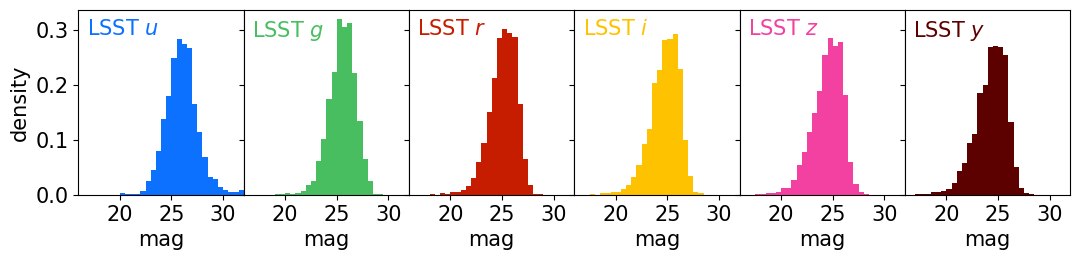

In [18]:
#Plot the broadband magnitudes(logarithmic) as predicted by the pop-cosmos model for Rubin
plt.rcParams.update({"font.size": 15})

x_bins = np.linspace(16, 32, 33)
figsize = (12.8, 2.4)
xlim = (16, 32)
xticks = [20, 25, 30]

fig, axes = plt.subplots(1, 6, figsize=figsize, sharey='row')

# Loop through all channels for a histogram plot
for idx in range(len(rubin_filter_names)):
    ax = axes[idx]
    ax.hist(rubin_magnitudes[:, idx], 
            color=rubin_filter_colors[idx], bins=x_bins, 
            linewidth=1.2, density=True)
    
    # Filter labels
    ax.text(0.05, 0.95, 'LSST ${}$'.format(rubin_filter_names[idx]), 
            color=rubin_filter_colors[idx], transform=ax.transAxes, verticalalignment='top')

    if idx == 0: 
        ax.set_ylabel('density')
    ax.set_xlim(xlim)
    ax.set_xlabel('mag')
    ax.set_xticks(xticks)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()

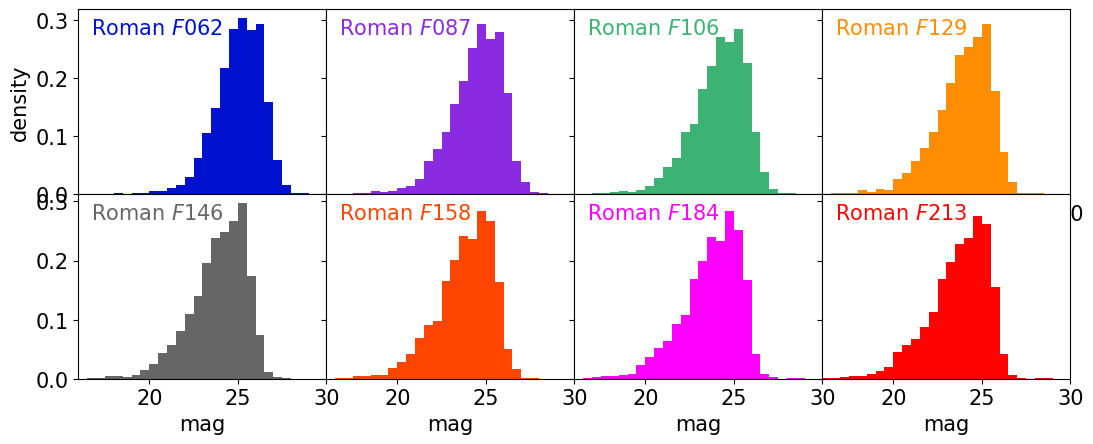

In [19]:
#Plot the broadband magnitudes(logarithmic) as predicted by the pop-cosmos model for Roman
plt.rcParams.update({"font.size": 15})

x_bins = np.linspace(16, 32, 33)
figsize = (12.8, 4.8)
xlim = (16, 30)
xticks = [20, 25, 30]

fig, axes = plt.subplots(2, 4, figsize=figsize, sharey='row')
axes = axes.flatten()

# Loop through all channels for a histogram plot
for idx in range(len(roman_filter_names)):
    ax = axes[idx]
    ax.hist(roman_magnitudes[:, idx], 
            color=roman_filter_colors[idx], bins=x_bins, 
            linewidth=1.2, density=True)
    
    # Filter labels
    ax.text(0.05, 0.95, 'Roman $F{}$'.format(roman_filter_names[idx]), 
            color=roman_filter_colors[idx], transform=ax.transAxes, verticalalignment='top')

    if idx == 0: 
        ax.set_ylabel('density')
    ax.set_xlim(xlim)
    ax.set_xlabel('mag')
    ax.set_xticks(xticks)
plt.subplots_adjust(hspace=0, wspace=0)
plt.show()